# Voice Recognition for Digits - Jimmy Fernandez and Christina Lau

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import librosa as lb 
import matplotlib.pyplot as plt
from scipy.signal import stft
import glob
import os.path
import subprocess
import pickle
import IPython.display as ipd
import warnings
import scipy.signal
import scipy.fftpack
import time
import json
from json import JSONEncoder

In [3]:
warnings.filterwarnings(action='ignore') # to suppress warning messages

In [4]:
#set true if you are using a mac
Mac = False

## Loading in Stored Variables

In order to substantially reduce the run time of this file, the following function is defined and run here. For explanation of this function, as well as to see it written in its original context, see later discussion in "Calculation and Storage" Section

In [5]:
resultsFile = 'results_storage.json'
resultsFileNoSplit = 'results_storage_no_split.json'

In [6]:
def loadAllVariables(resultsFile):
    """
    Helper function for the system. Loads in all the previously defined outputs so we no longer need to allow a long 
    file runtime to work with and analyze the results.
    
    This function works be making the variables global, as it would be cumbersome to return them all. The author recognizes 
    this is bad practice, but has decided to make an exception in this case due to pure convience
    
    Inputs:
    resultsFile - the name of the file which all the system results are stored
    
    Outputs:
    None returned (creates all the below global variables)
    """
    
    file = open(resultsFile)
    data = json.load(file)
    file.close()
    
    
    #load in data taken from noisy reference benchmark
    global confusionMatrix_n, calcsDone_n, timeElapsed_n
    confusionMatrix_n, calcsDone_n, timeElapsed_n = data['noise']
    confusionMatrix_n = np.array(confusionMatrix_n)
    
    #load in data taken from noisy reference benchmark, cosine metric
    global confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n
    confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n = data['noise_cosine']
    confusionMatrix_c_n = np.array(confusionMatrix_c_n)
    
    #load in data from denoised benchmark
    global confusionMatrix, calcsDone, timeElapsed
    confusionMatrix, calcsDone, timeElapsed = data['denoised']
    confusionMatrix = np.array(confusionMatrix)
    
    #load in data from denoised benchmark, cosine metric
    global confusionMatrix_c, calcsDone_c, timeElapsed_c
    confusionMatrix_c, calcsDone_c, timeElapsed_c = data['denoised_cosine']
    confusionMatrix_c = np.array(confusionMatrix_c)
    
    #load in data from noisy benchmark, desilenced
    global confusionMatrix_nds, calcsDone_nds, timeElapsed_nds
    confusionMatrix_nds, calcsDone_nds, timeElapsed_nds = data['desilenced']
    confusionMatrix_nds = np.array(confusionMatrix_nds)
    
    #load in data from noisy benchmark, desilenced, cosine metric
    global confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds
    confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds = data['desilenced_cosine']
    confusionMatrix_c_nds = np.array(confusionMatrix_c_nds)
    
    #load in data from denoised, desilenced benchmark
    global confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds
    confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds = data['dd']
    confusionMatrix_ddds = np.array(confusionMatrix_ddds)
    
    #load in data from denosied, desilenced benchmark, cosine metric
    global confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds
    confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds = data['dd_cosine']
    confusionMatrix_c_ddds = np.array(confusionMatrix_c_ddds)
    
    #load in data taken from noisy reference noisy queries benchmark
    global confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq
    confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq = data['noise_query_benchmark']
    confusionMatrix_nrnq = np.array(confusionMatrix_nrnq)

    #load in data taken from noisy reference noisy queries benchmark, cosine metric
    global confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq
    confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq = data['noise_query_benchmark_cosine']
    confusionMatrix_c_nrnq = np.array(confusionMatrix_c_nrnq)
    
    #load in data taken from noisy reference desilenced noisy queries benchmark
    global confusionMatrix_ndrnq, calcsDone_ndrnq, timeElapsed_ndrnq
    confusionMatrix_ndrnq, calcsDone_ndrnq, timeElapsed_ndrnq = data['noise_query_desilenced_noise_ref_benchmark']
    confusionMatrix_ndrnq = np.array(confusionMatrix_ndrnq)
    
    #load in data taken from noisy reference desilenced noisy queries benchmark, cosine metric
    global confusionMatrix_c_ndrnq, calcsDone_c_ndrnq, timeElapsed_c_ndrnq
    confusionMatrix_c_ndrnq, calcsDone_c_ndrnq, timeElapsed_c_ndrnq = data['noise_query_desilenced_noise_ref_benchmark_cosine']
    confusionMatrix_c_ndrnq = np.array(confusionMatrix_c_ndrnq)

We use a similar function to reload all the "No Split" results from later in the file.

In [7]:
def loadAllVariablesNoSpit(resultsFile):
    """
    Helper function for the system. Loads in all the previously defined outputs from the "No Split" system so we no longer 
    need to allow a long file runtime to work with and analyze the results.
    
    This function works be making the variables global, as it would be cumbersome to return them all. The author recognizes 
    this is bad practice, but has decided to make an exception in this case due to pure convience
    
    Inputs:
    resultsFile - the name of the file which all the system results are stored
    
    Outputs:
    None returned (creates all the below global variables)
    """
    file = open(resultsFile)
    data = json.load(file)
    file.close()
    
    #load in data from denoised benchmark
    global confusionMatrixNoSplit, calcsDoneNoSplit, timeElapsedNoSplit
    confusionMatrixNoSplit, calcsDoneNoSplit, timeElapsedNoSplit = data['no_split_denoised']
    confusionMatrixNoSplit = np.array(confusionMatrixNoSplit)
    
    #load in data from denoised benchmark, cosine metric
    global confusionMatrixNoSplit_c, calcsDoneNoSplit_c, timeElapsedNoSplit_c
    confusionMatrixNoSplit_c, calcsDoneNoSplit_c, timeElapsedNoSplit_c = data['no_split_denoised_cosine']
    confusionMatrixNoSplit_c = np.array(confusionMatrixNoSplit_c)
    

In [8]:
loadAllVariables(resultsFile)
loadAllVariablesNoSpit(resultsFileNoSplit)

## MFCC Feature Calculation

Before diving into the MFCC algorithm, we first write a number of simple helper functions for use at various points of the algorithm. These functions convert the FFT frequency indcies to frequency in hz, hz to mels (on the non-linear Mel frequency scale), and vice versa.

In [9]:
def binToHz(k, nfft = 2048, fs = 22050):
    """
    Helper function that takes in an fft/stft frequency bin k and returns the corresponding frequency of the bin in hertz
    
    Inputs:
    k - the index of the stft row of interest
    
    Outputs:
    freq - the frequency of the provided STFT bin
    """
    
    freq = k*fs/nfft
    
    return freq

In [10]:
def hzToBin(freq, nfft = 2048, fs = 22050):
    """
    helper function that converts the provided frequency in hz to the nearest fft frequency index. Only valid for frequencies 
    contained within the first half of the fft 
    
    Inputs:
    freq - the frequency we are interested in converting to frequency index
    nfft - the size of the fft performed
    fs - the sample rate of the signal
    
    
    Outputs:
    k - converted frequency bin
    
    """
    
    k = np.round(freq*nfft/fs)
    
    return k

In [11]:
def hzToMel(hz):
    """
    Helper function that converts the provided hz frequency to mel frequency scale
    
    Inputs:
    hz - the frequency of interst in hz
    
    Outputs:
    mel - the frequency of interest in mel
    """
    
    mel = 1125*np.log(1 + hz/700)
    
    return mel

In [12]:
def melToHz(mel):
    """
    Helper function that converts the provided mel frequency to hz frequency scale
    
    Inputs:
    mel - the frequency of interest in mel
    
    Outputs:
    hz - the frequency of interst in hz
    """
    hz = 700*(np.exp(mel/1125) - 1)
    
    return hz

Now we implement the Mel Frequency Cepstrum Coefficent calculation for the features. The algorithm has 5 main steps.

1. Take the STFT of the audio signal. This is an implied step of our function, as it is passed the STFT as an input
2. Calculate the periodogram of the STFT. The Periodogram is the elementwise square magnitude of the STFT elements divided by the length of the FFT used to construct the STFT
3. Use the "Mel Frequency Filter Bank" to calculate the energies in a specified number of frequency bands. The Mel Frequency scale is a logarithmic scale that more closely matches the way humans hear/speak. As such, the filter bank sums energies in closely related frequency bins together to express the energy content in ranges more similar to human speech, with higher frequencies having a wider range summed together than lower frequencies
4. Take the natural logarithm of the mel energy bands
5. Take the discrete cosine transform of the logarithmic mel energy bands. These are the MFCC coefficients (there should be a specified number per frame of the STFT)

In [13]:
def mfcc(S, n_fft = 2048, sr = 22050, num_coeffs = 26, filterMatrix = None, bottomFreq = 300, topFreq = 8000, epsilon = 1e-9):
    """
    Performs the calculation of the MFCC feature matrix
    
    Inputs:
    S - the STFT of the audio signal of interest
    n_fft - the length of the DFT used to calculate the STFT
    sr = the sample rate of the audio of interest
    num_coeffs - the number of coefficients to return (and also the number of Mel Filters to create)
    bottomFreq - the bottom frequency of our filter bank. Defaults to 300 hz because this is a common bottom used in speech recognition
    topFreq - the top frequency of our filter bank. Defaults to 8000 hz because this is a common top used in speech recognition
    epsilon - a small number added to the logarithm to prevent NaN's
    
    Outputs:
    mfcc - a num_coeffs x number of STFT frames matrix that represents the MFCC feature per frame of the STFT
    
    """
    #we begin by calculating the periodogram of the provided STFT matrix
    pxx= np.abs(S)**2/n_fft

    
    #use a precalculated filter matrix to make the calculation slightly more efficient, if desired
    if filterMatrix is not None:
        assert(num_coeffs == filterMatrix.shape[0])
        filt = filterMatrix
    else:
        filt = calculateFilterMatrix(numFilters = num_coeffs, bottomFreq = bottomFreq, topFreq = topFreq)
        
    #sum the relevant filter energies and take the logarithm of them (part of the "cepstrum calculation")
    mel_log_energies = np.log(filt@pxx + epsilon)
    
    mfcc = scipy.fftpack.dct(mel_log_energies, axis = 0, norm = 'ortho') #norm is set to ortho for the preimplemented version
    
    
    return mfcc

In order to perform the above calculation. We write a helper function that calculates the filter bank as a matrix that can be used to premultiply the periodogram to perform the summation an filtering. To calculate the filter bank, we do the following

1. Take our upper and lower frequency bounds and convert them to mels
2. Generate a number of linearly spaced points between the endpoints equal to the number of desired filters
3. Convert the points to hz, then to FFT frequency bins
4. iterate through the filter matrix, and starting with the leftmost points, use groups of three points as the start, stop, and peak of the triangular filter. The amplitude ranges from 0 to 1 at the peak linearly and down to zero again.

In [14]:
def calculateFilterMatrix(numFilters = 26, bottomFreq = 300, topFreq = 8000,  nfft = 2048):
    """
    Helper function for the MFCC calculation that returns a matrix of size numfilters x nfft//2 + 1
    
    Inputs:
    numFilters - the desired number of filters
    bottomFreq - the bottom frequency of the filter bank
    topFreq - the top frequency of the filter bank
    nfft - the length of the fft
    
    
    Outputs:
    filterMatrix - a numfilters x nfft//2 + 1 matrix where each row is one of mel triangular filters
    
    """
    #calculating the upper and lower bounds of our functions
    lowerbound = hzToMel(bottomFreq)
    upperbound = hzToMel(topFreq)
    
    #calculate the end/peak points for the various filters
    freq_endpoints = melToHz(np.linspace(lowerbound, upperbound, num = numFilters + 2))
    endpoints = hzToBin(freq_endpoints)
    
    #iterate through every value of the matrix
    filterMatrix = np.zeros((numFilters, nfft//2 + 1))
    for filt in range(numFilters):
        
        #retrieve end points for use in the filter calculating function
        start = endpoints[filt]
        peak = endpoints[filt + 1]
        stop = endpoints[filt + 2]
        
        #calculate the proper amplitude of the triangle filter
        for k in range(nfft//2 + 1):
            
            if k >= start and k <= peak:
                filterMatrix[filt, k] = (k - start)/(peak - start)
            elif k >= peak and k <= stop:
                filterMatrix[filt, k] = (stop - k)/(stop - peak)
            else:
                filterMatrix[filt, k] = 0
        
    
    return filterMatrix

Now that we have a working implementation of the mfcc calculation, we implement a second version which cuts out a specified number of the higher frequency mfccs, and instead appends approximations for the 1st, 2nd... order derivatives to the top of the feature matrix.

In [15]:
def mfcc2(S, keep = 12, deltaOrders = 2, n_fft = 2048, sr = 22050, num_coeffs = 26, filterMatrix = None, bottomFreq = 300, topFreq = 8000, epsilon = 1e-9):
    """
    Performs the calculation of the MFCC feature matrix, keeps the specified number of bottom coefficients, and appends the specified number of deltas
    
    Inputs:
    S - the STFT of the audio signal of interest
    keep - the number of bottom coefficients to keep from the mfcc calculation with num_coeff amount of filters
    deltaOrders - starting with order = 1, the number of delta features to append to the final output feature matrix
    n_fft - the length of the DFT used to calculate the STFT
    sr = the sample rate of the audio of interest
    num_coeffs - the number of coefficients to return (and also the number of Mel Filters to create)
    bottomFreq - the bottom frequency of our filter bank. Defaults to 300 hz because this is a common bottom used in speech recognition
    topFreq - the top frequency of our filter bank. Defaults to 8000 hz because this is a common top used in speech recognition
    epsilon - a small number added to the logarithm to prevent NaN's
    
    Outputs:
    features - a feature matrix with the bottom keep coeffs being the mfcc features and the rest being delta coefficients of some order
    """
    
    #we begin by calculating the base mfcc features of the provided STFT
    baseFeats = mfcc(S, n_fft = n_fft, sr = sr, num_coeffs = num_coeffs, filterMatrix = filterMatrix, bottomFreq = bottomFreq, topFreq = topFreq, epsilon = epsilon)
    mfccKeep = np.copy(baseFeats[0:keep, :])
    
    #now we preallocate a matrix of the proper size to fill the final features
    numFrames = S.shape[1]
    numRows = keep*(deltaOrders + 1) #add a number of derivatives starting at order 1 (1st derivative), with the first keep mfcc features at the bottom
    features = np.zeros((numRows, numFrames))
    
    
    #place the first "keep" features into the
    features[0:keep, :] = mfccKeep
    
    
    #now we calculate all desired deltas and append them to the top of the feature matrix
    
    for ord in range(1,deltaOrders+1):
        
        #calculate the delta features of this order
        delta_x = lb.feature.delta(mfccKeep, order = ord)
        
        #store the delta features in the proper location of the final feature matrix
        features[(keep*ord): (keep)*(ord + 1), :] = delta_x
        
    return features
    

We now test all our miscellaneous functions

(-0.5, 1024.5, -0.5, 25.5)

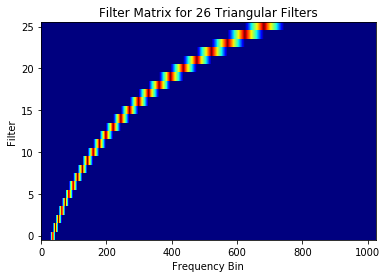

In [16]:
test = calculateFilterMatrix(numFilters = 26)
plt.imshow(test, cmap = 'jet', origin = 'lower')
plt.title("Filter Matrix for 26 Triangular Filters")
plt.ylabel("Filter")
plt.xlabel("Frequency Bin")
plt.axis('tight')

## Word Splitting

Here we write helper code that will help us split the queries into single digits and verify the functionality.

In [17]:
def getDigitTimes(queryName, denoisedQuery = None, hop_length = 128, top_db = 25):
    """
    Helper function that takes in the path for the query and returns an array containing the predicted non-silent segments
    
    Inputs:
    queryName - the full path of the query of interest
    denoisedQuery - optional parameter that can be used if using the denoised audio query is desired
    hop_length - the hop size in samples to use while splitting
    top_db - the maximum allowable decibel level
    
    Outputs:
    digits - an array containing the predicted digit splits.
    
    """ 
    if denoisedQuery is not None:
        basename = os.path.basename(queryName)
        filePath = os.path.join(denoisedQuery, basename)
    else:
        filePath = queryName
    
    audio, sr = lb.core.load(filePath)
    digits = lb.effects.split(audio, hop_length = hop_length, top_db = top_db)
    
    return digits

The following function is a helper function that will allow us to test how well our splitting function is working by letting us listen to each of the individual splits.

In [18]:
def playDigits(queryName, digitTimes, hop_length=128, sr = 22050):
    """
    Function that takes in an audio query and predicted digits splits and outputs a playable version of every split
    
    Inputs:
    queryName - the full pathname of the query of interest
    digitTimes - an array containing the predicted digit splits
    hop_length - the desired hop size in samples [outdated/legacy]
    sr - the sample rate of the audio file
    
    Outputs:
    None (plays all audio inline)
    """
    
    audio, sr = lb.core.load(queryName)

    for time in digitTimes:
        ipd.display(ipd.Audio(audio[time[0]:time[1]], rate = sr))
    

# Constructing the Database

To construct the database, we retrieve a list of all the mp3s in a specified directory, then iterate through them, calculating the mfcc feature matrix for each and storing it in a dictionary with a key specified in the file name.

In [19]:
def retrieveMP3s(indir, Mac = False):
    """
    Helper function to retrieve a list of all the .mp3 files listed in the provided directory
    Note: For macs, it's /*.mp3, for windows, it's \*.mp3
    
    Inputs:
    indir - the directory containing all the MP3s of interst
    Mac - a boolean indicating if the machine running the code is a Mac. If false, windows notation is assumed
    
    Outputs: 
    A list of all the mp3 file paths
    
    """
    #get the correct pathname based on the machine type
    if Mac: 
        pathname = indir + '/*.mp3'
    else:
        pathname = indir + '\*.mp3'
    
    return glob.glob(pathname)

In [20]:
def constructDB(indir, numFilters = 26, Mac = False, sr = 22050, nfft = 2048, hop = 128, strPosn = 4):
    """
    Function that constructs a database (dictionary) with the digit as a key and the MFCC feature matrix as the stored data
    
    Inputs: 
    indir - the label of the directory of interest
    Mac - a boolean indicating if the machine running this code is a mac. If false, 
          it is assumed that the code is running on a pc
    sr - the sample rate of the audio files in the directory
    nfft - the size of the fft we want to perform to to construct the stft
    hop - the hop size for the stft
    strPosn - the index of the reference name in the reference file. Used to label db
    
    Outputs:
    db - a dictionary object storing the MFCC coefficients for each of the digit references
    """
    
    db = {}
    mp3s = retrieveMP3s(indir, Mac = Mac)
    
    
    for i in range(len(mp3s)):
        
        #we begin by retreiving each individual mp3 and calculating the STFT
        currPath = mp3s[i]
        mp3, _ = lb.core.load(currPath, sr = sr)
        S = lb.core.stft(mp3, n_fft = nfft, hop_length = hop)
        
        #we then use calculate the MFCC feature matrix
        mfccMatrix = mfcc2(S, num_coeffs = numFilters, n_fft = nfft, sr = sr)
        #mfccMatrix = mfcc(S, num_coeffs = numFilters, n_fft = nfft, sr = sr)
        
        #finally we get the proper key name
        baseName = os.path.basename(currPath)
        keyName = baseName[strPosn] #assumes the file is in Reference_x.mp3 format
        
        #add data to the database
        db[keyName] = mfccMatrix
        
    
    return db

We use the above function to construct data bases for each set of references, which have various degrees of preprocessing done to them

In [21]:
#testing the db construction
dbDenoised = constructDB('denoisedReferences', Mac = Mac)

In [22]:
dbNoised = constructDB('newRef', Mac = Mac)

In [23]:
dbDenoisedNoSilence = constructDB('denoisedReferencesNoSilence', Mac = Mac)

In [24]:
dbNoisedNoSilence = constructDB('RefNoSilence', Mac = Mac)

To verify the functionality of the constructDB function, we plot each of the stored features and verified they are as expected

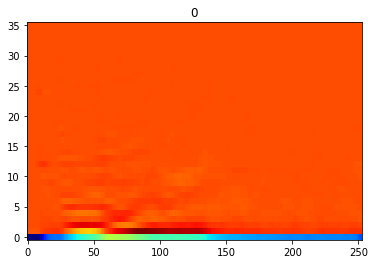

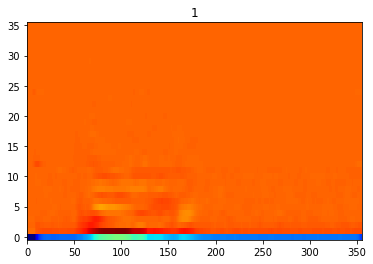

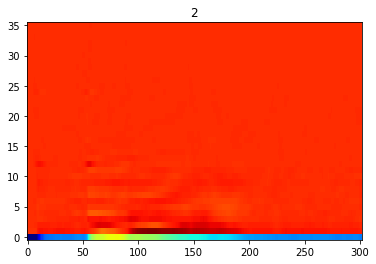

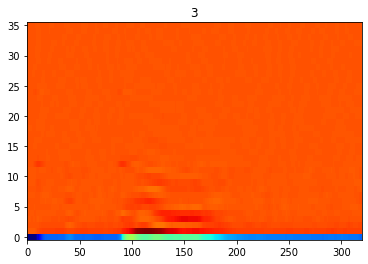

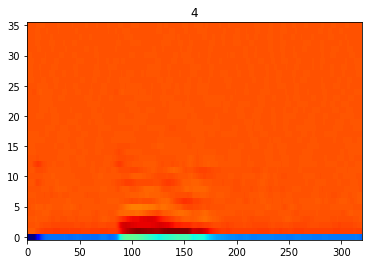

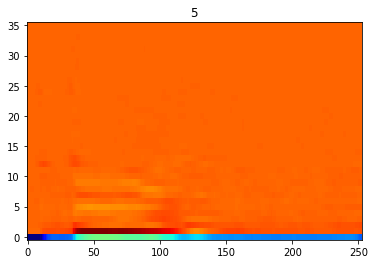

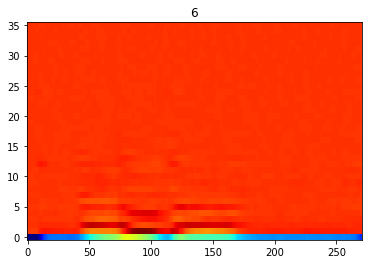

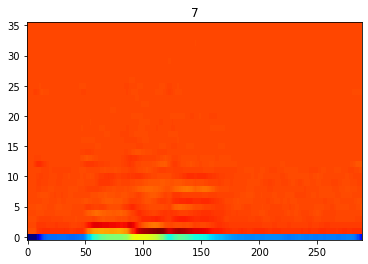

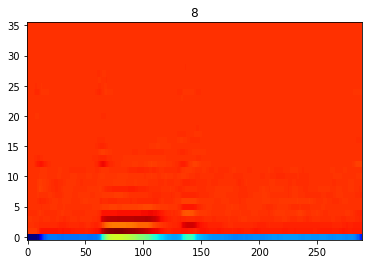

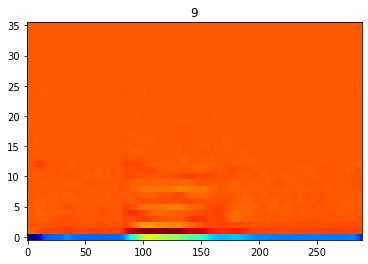

In [25]:
for key in dbDenoised:
    feats = dbDenoised[key]
    plt.imshow(feats, origin = 'lower', cmap = 'jet')
    plt.title(key)
    plt.axis('tight')
    plt.show()

## Benchmark 

In order to run the benchmark, we first write a function that can retrieve the ground truth answer to the query of interest. To simplify our answer storage, the ground truth label was set as the digit title.

In [26]:
def retrieveAnswer(pathname):
    """
    Helper function that takes in a .mp3 file whose name is a list of the digits spoken in the file and returns a 
    list of the characters
    
    Inputs:
    pathname - the pathname of the file of interest
    
    Outputs:
    answer - a list of the digits in the mp3's file name
    """
    
    basename = os.path.basename(pathname)[:-4]
    answer = [int(digit) for digit in list(basename)]
    
    
    return answer

We now write a variety of subfunctions that perform the prediction process for the system. The first one is a function that checks how well each reference matches to the provided audio query

In [27]:
def getMatchScores(audioQuery, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    Helper function that performs subsequency DTW on the audio file with each reference and returns the match scores.
    
    Inputs:
    audioQuery - the audio segment of interest
    db - the database being used to match the digit
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    predictions - a list of integers that is the best prediction of each of the digits being spoken in the full audio file
    times - the predicted places where the digit are located in the audio file
    """
    
    #we begin by calculating the mfcc of the query
    S = lb.core.stft(audioQuery, n_fft = nfft, hop_length = hop)
    mfcc_query = mfcc2(S, n_fft = nfft, sr = sr)
    #mfcc_query = mfcc(S, n_fft = nfft, sr = sr)
    
    #now we iterate through the database and compare all the numbers with subsequency dynamic time warping
    scores = []
    for key in db:
        
        mfcc_ref = db[key]
        
        D_num, wp_num = lb.sequence.dtw(mfcc_ref, mfcc_query, metric = metric, subseq = True)
        scores.append(np.min(D_num[-1:]))
        
#     predInd = np.argmin(scores)
#     predScore = scores[predInd]
    return scores

The following function was the first attempt at writing a function that would ensure that the digit splits resulted in the correct number of splits. It used knowledge from the ground truth label to ensure the match, and was thus eventually rewritten to avoid using "oracle" knowledge, ie information we shouldn't have access to in an unknown query

In [28]:
def getCleanedDigitsTimes(queryName, denoisedQuery = None, hop_length = 128, top_db = 25):
    """
    helper function that takes the returns audio query splits that are enforced to be the same length as the ground truth label. 
    NOTE: method is deprecated as it used oracle knowledge
    
    Inputs:
    audioQuery - the audio segment of interest
    denoisedQuery - optional parameter that can be used if using the denoised audio query is desired
    hop_length - the desired hop length in sample size
    top_db - the desired top decibel
    
    Outputs:
    times - splits for the audio query that have been enforced to match the same length as the ground truth
    """
    
    #begin by getting the splits as well as how many splits there should be
    desiredSplits = len(retrieveAnswer(queryName))
    times = getDigitTimes(queryName, denoisedQuery = denoisedQuery, hop_length = hop_length, top_db = top_db)
    
    while times.shape[0] > desiredSplits:
        times_copy = np.copy(times)
        times_copy[:,0] = times_copy[:,0]*-1
        lengths = np.sum(times_copy, axis = 1)
        toRemove = np.argmin(lengths)
        
        times = np.delete(times, toRemove, 0)
        
    #if the times array started off less than the current array, just return an empty array (the benchmark will ignore it)
    if times.shape[0] < desiredSplits:
        times = np.array([])

    return times

The second iteration of the improved splitting algorithm is shown below. It enforces a minimum silence length between words and deletes segments that are considered too short to be a word. This iteration was successful in accurately splitting all 100 queries without outside information

In [29]:
def getCleanedDigitsTimesMerged(queryName, denoisedQuery = None, minSplitTime = 0.24, hop_length = 128, top_db = 25, sr = 22050):
    """
    Helper function that systematically merges splits that are suspected to be from the same digit. It also removes suspected noise
    
    Inputs:
    queryName - the path of the query of interest
    denoisedQuery - optional parameter that can be used if using the denoised audio query is desired
    minSplitTime - a paramemter specifying the minimum length of silence between splits in seconds
    hop_length - the desired hop length in samples
    top_db - the desired top decibel level
    sr - the sample rate of the audio signal
    
    Outputs:
    finalTimes - a processed array of predicted digit splits
    """
    
    minSplitLength = np.round(minSplitTime / (1 / sr))
    
    #begin by getting the splits as well as how many splits there should be
    times = getDigitTimes(queryName, denoisedQuery = denoisedQuery, hop_length = hop_length, top_db = top_db)
    
    mergedTimes = [];
    finalTimes = [];
    timesList = list(times)
    
    # Initial Merges
    while len(timesList) != 0:
    
        if(len(timesList) >= 2):
            firstSplit = timesList[0]
            secondSplit = timesList[1]
            if (secondSplit[0] - firstSplit[1] < minSplitLength):
                mergedTimes.append([firstSplit[0], secondSplit[1]])
                timesList.pop(0)
            else:
                mergedTimes.append(timesList[0]);
                timesList.pop(0)
        else:
            mergedTimes.append(timesList[0]);
            timesList.pop(0)
            
    # Merge any splits with overlapping times
    while len(mergedTimes) != 0:
        if(len(mergedTimes) >= 2):
            first = mergedTimes[0]
            second = mergedTimes[1]
            
            if (second[0] - first[1] < 0):
                
                finalTimes.append([first[0], second[1]])
                
                mergedTimes.pop(1)
                mergedTimes.pop(0)
                
            else:
                finalTimes.append(mergedTimes[0]);
                mergedTimes.pop(0)
        else:
            finalTimes.append(mergedTimes[0]);
            mergedTimes.pop(0)
            
    #mergedTimes = [time for time in mergedTimes if (time[1] - time[0]) > 1000]
    finalTimes = [time for time in finalTimes if (time[1] - time[0]) > 1000]
    
    return np.array(finalTimes)

The following two functions use the previous functions to get a full list of predictions for a provided audio query.

In [30]:
def getPrediction(audioQuery, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    Helper function that retrieves the prediction for a single audio segment, which is assumed to have been split already
    
    Inputs:
    audioQuery - the audio segment of interest
    db - the database being used to match the digit
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    prediction - an integer that is the best prediction of the digit being spoken in the audio segment
    """
    #retrieve all the match scores using subsequence DTW
    matchScores = getMatchScores(audioQuery, db, sr = sr, nfft = nfft, hop = hop, metric = metric)
    refList = list(db.keys())
    
    #choose the best match score
    predInd = np.argmin(matchScores)
    prediction = int(refList[predInd])
    
    return prediction

In [31]:
def getPredictions(queryPath, db, denoisedQuery = None, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    Function that predicts the digits contained in a full audio query
    
    Inputs:
    audioPath - the audio path of interest
    db - the database being used to match the digit
    denoisedQuery - an optional parameter that allows use of the denoised query variant
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    top_db - the desired top decibel level
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    predictions - a list of integers that is the best prediction of each of the digits being spoken in the full audio file
    times - the predicted places where the digit are located in the audio file
    """
    predictions = []
    #times = getCleanedDigitsTimes(queryPath, hop_length = hop, top_db = top_db)
    times = getCleanedDigitsTimesMerged(queryPath, denoisedQuery = denoisedQuery, hop_length = hop, top_db = top_db)
    
    if times.size == 0:
        return []
    
    audio, _ = lb.core.load(queryPath, sr)
    
    for i in range(times.shape[0]):
        startTime = times[i, 0]
        endTime = times[i, 1]
        audioClip = audio[startTime:endTime]
        currPred = getPrediction(audioClip, db, sr = sr, nfft = nfft, hop = hop, metric = metric)
        
        predictions.append(currPred)
        
    #return predictions
    return predictions, times

Using all these functions, we construct a function to test the system using all the queries

In [32]:
def runBenchmark(indir, db, denoisedQuery = None, Mac = False, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    Runs a benchmark for our system 
    
    Inputs:
    indir - the directory where the mp3 queries are located
    
    Output:
    confusionMatrix - a 10x10 confusion matrix, where the row indicates the digit guess, and the 
                      column indicates the ground truth
    calcsDone - an integer indicating how many queries were processed
    timeElapsed - a float indicating how long it took the benchmark to run
    """
    
    startTime = time.time()
    
    confusionMatrix = np.zeros((10,10))
    
    #we begin by retrieving all the paths to our queries
    mp3s = retrieveMP3s(indir, Mac = Mac)
    
    calcsDone = len(mp3s)
    for i in range(len(mp3s)):
        
        currPath = mp3s[i]
        predictions, times = getPredictions(currPath, db, denoisedQuery = denoisedQuery, sr = sr, nfft = nfft, hop = hop, top_db = top_db, metric = metric)
        
        if len(predictions) == 0:
            calcsDone -= 1
            pass
        
        answers = retrieveAnswer(currPath)
        
        #assert(len(answers) == len(predictions))
        if (len(answers) != len(predictions)):
            calcsDone -= 1
            print(answers)
            print(predictions)
            pass
        
        for j in range(len(answers)):
            confusionMatrix[predictions[j], answers[j]] += 1
            
    endTime = time.time()
    timeElapsed = endTime - startTime
                    
    return confusionMatrix, calcsDone, timeElapsed

These functions now allow us to test the system under various different conditions. Note that any commented out calculations are not performed as the results have already been saved and reloaded in.

In [33]:
#done w/ euclidean distance metric
#confusionMatrix, calcsDone, timeElapsed = runBenchmark('denoisedQueries', dbDenoised, Mac= Mac) 

In [34]:
print(confusionMatrix)
print()
print(calcsDone)
print()
print(timeElapsed)

[[45.  0.  0.  2.  1.  0.  1.  5.  0.  0.]
 [ 0. 62.  0.  0. 10.  6.  0.  0.  0.  1.]
 [ 1.  0. 45.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 27. 47.  0.  0.  0.  0.  8.  0.]
 [ 0.  3.  0.  0. 51.  0.  0.  0.  0.  0.]
 [ 0.  0.  2. 11.  0. 56.  0.  2.  0.  1.]
 [ 0.  0.  0.  4.  0.  0. 44. 22.  8.  0.]
 [ 0.  4.  0.  0.  0.  0.  0. 30.  0. 15.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 38.  0.]
 [ 0.  0.  0.  0.  0.  2.  0.  1.  0. 30.]]

100

104.00722289085388


In [35]:
np.sum(confusionMatrix)/timeElapsed

5.624609365965903

In [36]:
#done w/ cosine similarity metric
#confusionMatrix_c, calcsDone_c, timeElapsed_c = runBenchmark('denoisedQueries', dbDenoised, metric = 'cosine', Mac= Mac) 

In [37]:
print(confusionMatrix_c)
print()
print(calcsDone_c)
print()
print(timeElapsed_c)

[[44.  0.  0.  2.  0.  0.  2.  0.  0.  0.]
 [ 0. 39.  2.  0. 19.  3.  0.  0.  0.  2.]
 [ 2.  2. 68.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2. 52.  0.  0.  0.  0. 15.  0.]
 [ 0. 13.  0.  1. 43.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  6.  0. 59.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.  0. 43.  9.  8.  0.]
 [ 0. 15.  0.  0.  0.  1.  0. 51.  0. 20.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 31.  0.]
 [ 0.  0.  1.  3.  0.  1.  0.  0.  0. 22.]]

100

102.75224113464355


In [38]:
totalQueryDigits = 0
mp3s = retrieveMP3s('denoisedQueries', Mac = Mac)
for i in range(len(mp3s)):
    mp3 = mp3s[i]
    numDigits = len(retrieveAnswer(mp3))
    totalQueryDigits += numDigits

In [39]:
print(totalQueryDigits)

585


## Metric Calculations

We write a few simple functions to calculate confusion matrix metrics, starting with basic precision and recall

- Precision: For one classification, the proportion of predictions that were correctly classified
- Recall: For one classification, the proportion of the total ground truth population that were correctly predicted

Sources: 

https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

As another note, some of the comments used to test the metric functions are oudated, as they were correct for the first working version of the system.

In [40]:
def precision(confusionMatrix, predRow):
    """
    Function that calculates the precision of the category corresponding to the provided row
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    predRow - the row corresponding to the category on which we make our calculation
    
    Outputs:
    precision - the precision of specified category
    """
    
    truePositives = confusionMatrix[predRow, predRow]
    totalPredictions = np.sum(confusionMatrix[predRow])
    precision = truePositives/totalPredictions
    
    if np.isnan(precision):
        return 0
    
    return precision

In [41]:
#hand calc says we had 34.65% precision for digit zero from the cosine metric, 76.92% precision for digit 9
zero_prec = precision(confusionMatrix_c, 0)
nine_prec = precision(confusionMatrix_c, 9)
print(zero_prec)
print(nine_prec)

0.9166666666666666
0.8148148148148148


In [42]:
def recall(confusionMatrix, predRow):
    """
    Function that calculates the recall of the category corresponding to the provided row
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    predRow - the row corresponding to the category on which we make our calculation
    
    Outputs:
    recall - the recall of the specified category
    """
    
    truePositives = confusionMatrix[predRow, predRow]
    totalPositives = np.sum(confusionMatrix[:, predRow])
    recall = truePositives/totalPositives
    
    if np.isnan(recall):
        return 0
    
    return recall

In [43]:
#hand calc says we had 91.94% recall on digit 4 for the euclidean metric, 33.33% recall on digit 1 for euclidean metric
four_recall = recall(confusionMatrix, 4)
one_recall = recall(confusionMatrix, 1)
print(four_recall)
print(one_recall)

0.8225806451612904
0.8985507246376812


In [44]:
def totalAccuracy(confusionMatrix, fullDigitCount):
    """
    Function that calculates what we've defined to be the "verifiable accuracy", the accuracy of queries for which we can check 
    for the correct answer because the digits were split properly, and the "full system accuracy", the accuracy of the system 
    that treats a test with incorrect splits as being incorrect
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    fullDigitCount - the total number of digits in the set of queries
    
    Outputs:
    verifiableAccuracy - the accuracy of the queries the system was able to correctly evaluate (defined above)
    fullSystemAccuracy - the accuracy of the full query test, where queries that can't be checked properly are treated as 
                         being incorrect
    """
    totalCorrect = np.trace(confusionMatrix)
    totalDigitsTested = np.sum(confusionMatrix)
    
    verifiableAccuracy = totalCorrect/totalDigitsTested
    
    fullSystemAccuracy = totalCorrect/fullDigitCount
    
    return verifiableAccuracy, fullSystemAccuracy

In [45]:
euclideanAccuracy = totalAccuracy(confusionMatrix, totalQueryDigits)
cosineAccuracy = totalAccuracy(confusionMatrix_c, totalQueryDigits)
print(euclideanAccuracy)
print(cosineAccuracy)

(0.7658119658119659, 0.7658119658119659)
(0.7726495726495727, 0.7726495726495727)


Now we calculate the F1-Score, a combined metric that uses the "harmonic mean" to aggregate the precision and recall scores of one of the classifiers

In [46]:
def F1Score(confusionMatrix, predRow):
    """
    Function that calculates the F1 score for a category, the harmonic mean of the category precision and recall
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    predRow - the row corresponding to the category on which we make our calculation
    
    Outputs:
    f1 - the f1 score of the specified category
    """
    
    prec = precision(confusionMatrix, predRow)
    rec = recall(confusionMatrix, predRow)
    
    f1 = (2*prec*rec) / (prec + rec)
    
    if np.isnan(f1):
        return 0
    
    return f1

In [47]:
#via handcalc, we see that the f1-score for 5 with the euclidean metric is 78.05%
#f1_five = F1Score(confusionMatrix, 5)
f1_one = F1Score(confusionMatrix, 1)
print(f1_one)

0.8378378378378378


Now we write a function that calculate the Macro F1 score, which is an equally weighted average of all classifier F1-scores

In [48]:
def macroF1(confusionMatrix):
    """
    Function that calculates the Macro F1 score for the confusion matrix, which is the arithmetic mean of each
    category's F1 score
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    predRow - the row corresponding to the category on which we make our calculation
    
    Outputs:
    macroF1 - the average F1 score of the entire system
    """
    numClassifiers = confusionMatrix.shape[0]
    f1scores = []
    
    for i in range(numClassifiers):
        f1 = F1Score(confusionMatrix, i)
        f1scores.append(f1)
        
        
    macroF1 = np.mean(f1scores)
    
    return macroF1

In [49]:
#estimated 46.48%
macroF1(confusionMatrix)

0.7676506037458101

In [50]:
macroF1(confusionMatrix_c)

0.7678560151649416

Now I use all these functions to bring all the metrics together

In [51]:
def fullReport(confusionMatrix, fullDigitCount, label):
    """
    Function that produces a print out of all the metric results for the provided confusion matrix
    
    Inputs:
    confusionMatrix - the confusion matrix of interest
    fullDigitCount - the total number of digits in the set of queries
    label - a string that is added to the title of the printout to help distinguish this printout from others
    
    Outputs:
    None
    """
    print("Full Metric output for benchmark: ", label)
    
    print()
    
    print("Digit  \t\tPrecision  \tRecall  \tF1-Score" )
    
    for digit in range(confusionMatrix.shape[0]):
        
        prec = precision(confusionMatrix, digit )
        rec = recall(confusionMatrix, digit )
        f1 = F1Score(confusionMatrix, digit )
     
        print(digit, "\t\t", f'{prec:.4f}', "\t", f'{rec:.4f}',"\t", f'{f1:.4f}' )
        
    print()
    
    macro = macroF1(confusionMatrix)
    verAcc, sysAcc = totalAccuracy(confusionMatrix, fullDigitCount)
    print("Macro F1 Score: ", f'{macro:.4f}')
    print("Full Digit Verifiable Accuracy: ", f'{verAcc:.4f}')
    print("Full Digit System Accuracy: ", f'{sysAcc:.4f}')

In [52]:
fullReport(confusionMatrix, totalQueryDigits, "Full Test, Euclidean Metric")

Full Metric output for benchmark:  Full Test, Euclidean Metric

Digit  		Precision  	Recall  	F1-Score
0 		 0.8333 	 0.9783 	 0.9000
1 		 0.7848 	 0.8986 	 0.8378
2 		 0.9783 	 0.6081 	 0.7500
3 		 0.5732 	 0.7344 	 0.6438
4 		 0.9444 	 0.8226 	 0.8793
5 		 0.7778 	 0.8750 	 0.8235
6 		 0.5641 	 0.9778 	 0.7154
7 		 0.6122 	 0.5000 	 0.5505
8 		 1.0000 	 0.7037 	 0.8261
9 		 0.9091 	 0.6383 	 0.7500

Macro F1 Score:  0.7677
Full Digit Verifiable Accuracy:  0.7658
Full Digit System Accuracy:  0.7658


In [53]:
fullReport(confusionMatrix_c, totalQueryDigits, "Full Test, Cosine Metric")

Full Metric output for benchmark:  Full Test, Cosine Metric

Digit  		Precision  	Recall  	F1-Score
0 		 0.9167 	 0.9565 	 0.9362
1 		 0.6000 	 0.5652 	 0.5821
2 		 0.9444 	 0.9189 	 0.9315
3 		 0.7536 	 0.8125 	 0.7820
4 		 0.7544 	 0.6935 	 0.7227
5 		 0.8551 	 0.9219 	 0.8872
6 		 0.7167 	 0.9556 	 0.8190
7 		 0.5862 	 0.8500 	 0.6939
8 		 1.0000 	 0.5741 	 0.7294
9 		 0.8148 	 0.4681 	 0.5946

Macro F1 Score:  0.7679
Full Digit Verifiable Accuracy:  0.7726
Full Digit System Accuracy:  0.7726


## Calculations And Storage

In order to reduce run time on this file, the calculations are performed and then stored into a json file for subseuent retrieval. The json library is modified in order to allow storage of numpy arrays. This was done using code from the following source, all credit and thanks go the author Vishal Hule.

https://pynative.com/python-serialize-numpy-ndarray-into-json/

In [54]:
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [55]:
# resultsFile = 'results_storage.json'
# resultsFileNoSplit = 'results_storage_no_split.json'

In [56]:
# dataToStore = {}

In [57]:
# dataToStoreNoSplit = {}

### Noisy References

In [58]:
# confusionMatrix_n, calcsDone_n, timeElapsed_n = runBenchmark('denoisedQueries', dbNoised, Mac = Mac)

In [59]:
# confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n = runBenchmark('denoisedQueries', dbNoised, metric = 'cosine', Mac = Mac) 

In [60]:
# dataToStore['noise'] = (confusionMatrix_n, calcsDone_n, timeElapsed_n)
# dataToStore['noise_cosine'] = (confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n)

### Denoised References

In [61]:
# dataToStore['denoised'] = (confusionMatrix, calcsDone, timeElapsed)
# dataToStore['denoised_cosine'] = (confusionMatrix_c, calcsDone_c, timeElapsed_c)

### Noisy References Desilenced

In [62]:
# confusionMatrix_nds, calcsDone_nds, timeElapsed_nds = runBenchmark('denoisedQueries', dbNoisedNoSilence, Mac = Mac)

In [63]:
# confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds = runBenchmark('denoisedQueries', dbNoisedNoSilence, metric = 'cosine', Mac = Mac) 

In [64]:
# dataToStore['desilenced'] = (confusionMatrix_nds, calcsDone_nds, timeElapsed_nds)
# dataToStore['desilenced_cosine'] = (confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds)

### Denoised References Desilenced

In [65]:
# confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds = runBenchmark('denoisedQueries', dbDenoisedNoSilence, Mac = Mac)

In [66]:
# confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds = runBenchmark('denoisedQueries', dbDenoisedNoSilence, metric = 'cosine', Mac = Mac) 

In [67]:
# dataToStore['dd'] = (confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds)
# dataToStore['dd_cosine'] = (confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds)

### Noisy References and Noisy Queries

In [68]:
# confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq = runBenchmark('Queries', dbNoised, denoisedQuery = 'denoisedQueries', Mac = Mac)

In [69]:
# confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq = runBenchmark('Queries', dbNoised, denoisedQuery = 'denoisedQueries', metric = 'cosine', Mac = Mac) 

In [70]:
# dataToStore['noise_query_benchmark'] = (confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq)
# dataToStore['noise_query_benchmark_cosine'] = (confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq)

### Noisy References Desilenced and Noisy Queries

In [71]:
# confusionMatrix_ndrnq, calcsDone_ndrnq, timeElapsed_ndrnq = runBenchmark('Queries', dbNoisedNoSilence, denoisedQuery = 'denoisedQueries', Mac = Mac)

In [72]:
# confusionMatrix_c_ndrnq, calcsDone_c_ndrnq, timeElapsed_c_ndrnq = runBenchmark('Queries', dbNoisedNoSilence, denoisedQuery = 'denoisedQueries', metric = 'cosine', Mac = Mac)

In [73]:
# dataToStore['noise_query_desilenced_noise_ref_benchmark'] = (confusionMatrix_ndrnq, calcsDone_ndrnq, timeElapsed_ndrnq)
# dataToStore['noise_query_desilenced_noise_ref_benchmark_cosine'] = (confusionMatrix_c_ndrnq, calcsDone_c_ndrnq, timeElapsed_c_ndrnq)

### Storage into a JSON File

In [74]:
# with open(resultsFile,'w') as file:
#     json.dump(dataToStore, file, cls=NumpyArrayEncoder) 

In [75]:
# def loadAllVariables(resultsFile):
#     """
#     Helper function for the system. Loads in all the previously defined outputs so we no longer need to allow a long 
#     file runtime to work with and analyze the results.
    
#     This function works be making the variables global, as it would be cumbersome to return them all. The author recognizes 
#     this is bad practice, but has decided to make an exception in this case due to pure convience
#     """
    
#     file = open(resultsFile)
#     data = json.load(file)
#     file.close()
    
    
#     #load in data taken from noisy reference benchmark
#     global confusionMatrix_n, calcsDone_n, timeElapsed_n
#     confusionMatrix_n, calcsDone_n, timeElapsed_n = data['noise']
#     confusionMatrix_n = np.array(confusionMatrix_n)
    
#     #load in data taken from noisy reference benchmark, cosine metric
#     global confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n
#     confusionMatrix_c_n, calcsDone_c_n, timeElapsed_c_n = data['noise_cosine']
#     confusionMatrix_c_n = np.array(confusionMatrix_c_n)
    
#     #load in data from denoised benchmark
#     global confusionMatrix, calcsDone, timeElapsed
#     confusionMatrix, calcsDone, timeElapsed = data['denoised']
#     confusionMatrix = np.array(confusionMatrix)
    
#     #load in data from denoised benchmark, cosine metric
#     global confusionMatrix_c, calcsDone_c, timeElapsed_c
#     confusionMatrix_c, calcsDone_c, timeElapsed_c = data['denoised_cosine']
#     confusionMatrix_c = np.array(confusionMatrix_c)
    
#     #load in data from noisy benchmark, desilenced
#     global confusionMatrix_nds, calcsDone_nds, timeElapsed_nds
#     confusionMatrix_nds, calcsDone_nds, timeElapsed_nds = data['desilenced']
#     confusionMatrix_nds = np.array(confusionMatrix_nds)
    
#     #load in data from noisy benchmark, desilenced, cosine metric
#     global confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds
#     confusionMatrix_c_nds, calcsDone_c_nds, timeElapsed_c_nds = data['desilenced_cosine']
#     confusionMatrix_c_nds = np.array(confusionMatrix_c_nds)
    
#     #load in data from denoised, desilenced benchmark
#     global confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds
#     confusionMatrix_ddds, calcsDone_ddds, timeElapsed_ddds = data['dd']
#     confusionMatrix_ddds = np.array(confusionMatrix_ddds)
    
#     #load in data from denosied, desilenced benchmark, cosine metric
#     global confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds
#     confusionMatrix_c_ddds, calcsDone_c_ddds, timeElapsed_c_ddds = data['dd_cosine']
#     confusionMatrix_c_ddds = np.array(confusionMatrix_c_ddds)
    
    
#     #load in data taken from noisy reference noisy queries benchmark
#     global confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq
#     confusionMatrix_nrnq, calcsDone_nrnq, timeElapsed_nrnq = data['noise_query_benchmark']
#     confusionMatrix_nrnq = np.array(confusionMatrix_nrnq)
    
#     #load in data taken from noisy reference noisy queries benchmark, cosine metric
#     global confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq
#     confusionMatrix_c_nrnq, calcsDone_c_nrnq, timeElapsed_c_nrnq = data['noise_query_benchmark_cosine']
#     confusionMatrix_c_nrnq = np.array(confusionMatrix_c_nrnq)

## Output Results

In this section, we see the result printouts for all the various different conditions we imposed on the system, including a different comparison metric, and various different reference preprocessing

### Noisy References

In [76]:
fullReport(confusionMatrix_n, totalQueryDigits, "Full Test, Euclidean Metric With Noise")

Full Metric output for benchmark:  Full Test, Euclidean Metric With Noise

Digit  		Precision  	Recall  	F1-Score
0 		 0.8947 	 0.7391 	 0.8095
1 		 0.3375 	 0.7826 	 0.4716
2 		 1.0000 	 0.2027 	 0.3371
3 		 0.2500 	 0.1406 	 0.1800
4 		 0.5641 	 0.3548 	 0.4356
5 		 0.9123 	 0.8125 	 0.8595
6 		 0.3387 	 0.9333 	 0.4970
7 		 0.3721 	 0.2667 	 0.3107
8 		 0.8723 	 0.7593 	 0.8119
9 		 0.5769 	 0.3191 	 0.4110

Macro F1 Score:  0.5124
Full Digit Verifiable Accuracy:  0.5128
Full Digit System Accuracy:  0.5128


In [77]:
fullReport(confusionMatrix_c_n, totalQueryDigits, "Full Test, Cosine Metric With Noise")

Full Metric output for benchmark:  Full Test, Cosine Metric With Noise

Digit  		Precision  	Recall  	F1-Score
0 		 0.9388 	 1.0000 	 0.9684
1 		 0.8472 	 0.8841 	 0.8652
2 		 1.0000 	 0.9595 	 0.9793
3 		 0.9683 	 0.9531 	 0.9606
4 		 0.9500 	 0.9194 	 0.9344
5 		 1.0000 	 0.9531 	 0.9760
6 		 0.9149 	 0.9556 	 0.9348
7 		 0.8551 	 0.9833 	 0.9147
8 		 1.0000 	 0.9444 	 0.9714
9 		 0.9524 	 0.8511 	 0.8989

Macro F1 Score:  0.9404
Full Digit Verifiable Accuracy:  0.9402
Full Digit System Accuracy:  0.9402


### Denoised References

In [78]:
fullReport(confusionMatrix, totalQueryDigits, "Full Test, Euclidean Metric, Denoised")

Full Metric output for benchmark:  Full Test, Euclidean Metric, Denoised

Digit  		Precision  	Recall  	F1-Score
0 		 0.8333 	 0.9783 	 0.9000
1 		 0.7848 	 0.8986 	 0.8378
2 		 0.9783 	 0.6081 	 0.7500
3 		 0.5732 	 0.7344 	 0.6438
4 		 0.9444 	 0.8226 	 0.8793
5 		 0.7778 	 0.8750 	 0.8235
6 		 0.5641 	 0.9778 	 0.7154
7 		 0.6122 	 0.5000 	 0.5505
8 		 1.0000 	 0.7037 	 0.8261
9 		 0.9091 	 0.6383 	 0.7500

Macro F1 Score:  0.7677
Full Digit Verifiable Accuracy:  0.7658
Full Digit System Accuracy:  0.7658


In [79]:
fullReport(confusionMatrix_c, totalQueryDigits, "Full Test, Cosine Metric, Denoised")

Full Metric output for benchmark:  Full Test, Cosine Metric, Denoised

Digit  		Precision  	Recall  	F1-Score
0 		 0.9167 	 0.9565 	 0.9362
1 		 0.6000 	 0.5652 	 0.5821
2 		 0.9444 	 0.9189 	 0.9315
3 		 0.7536 	 0.8125 	 0.7820
4 		 0.7544 	 0.6935 	 0.7227
5 		 0.8551 	 0.9219 	 0.8872
6 		 0.7167 	 0.9556 	 0.8190
7 		 0.5862 	 0.8500 	 0.6939
8 		 1.0000 	 0.5741 	 0.7294
9 		 0.8148 	 0.4681 	 0.5946

Macro F1 Score:  0.7679
Full Digit Verifiable Accuracy:  0.7726
Full Digit System Accuracy:  0.7726


### Noisy References Desilenced

In [80]:
fullReport(confusionMatrix_nds, totalQueryDigits, "Full Test, Euclidean Metric With Noise, Desilenced References")

Full Metric output for benchmark:  Full Test, Euclidean Metric With Noise, Desilenced References

Digit  		Precision  	Recall  	F1-Score
0 		 1.0000 	 0.1739 	 0.2963
1 		 0.3017 	 0.7826 	 0.4355
2 		 1.0000 	 0.1216 	 0.2169
3 		 0.2500 	 0.1250 	 0.1667
4 		 0.5000 	 0.3710 	 0.4259
5 		 0.8529 	 0.4531 	 0.5918
6 		 0.0723 	 0.1333 	 0.0938
7 		 0.3784 	 0.2333 	 0.2887
8 		 0.2766 	 0.7222 	 0.4000
9 		 0.5000 	 0.1702 	 0.2540

Macro F1 Score:  0.3169
Full Digit Verifiable Accuracy:  0.3385
Full Digit System Accuracy:  0.3385


In [81]:
fullReport(confusionMatrix_c_nds, totalQueryDigits, "Full Test, Cosine Metric With Noise, Desilenced References")

Full Metric output for benchmark:  Full Test, Cosine Metric With Noise, Desilenced References

Digit  		Precision  	Recall  	F1-Score
0 		 0.9000 	 0.9783 	 0.9375
1 		 0.7532 	 0.8406 	 0.7945
2 		 1.0000 	 0.9054 	 0.9504
3 		 0.9683 	 0.9531 	 0.9606
4 		 0.9048 	 0.9194 	 0.9120
5 		 0.9792 	 0.7344 	 0.8393
6 		 0.7917 	 0.4222 	 0.5507
7 		 0.8551 	 0.9833 	 0.9147
8 		 0.6000 	 0.8889 	 0.7164
9 		 0.8864 	 0.8298 	 0.8571

Macro F1 Score:  0.8433
Full Digit Verifiable Accuracy:  0.8547
Full Digit System Accuracy:  0.8547


### Denoised References Desilenced

In [82]:
fullReport(confusionMatrix_ddds, totalQueryDigits, "Full Test, Euclidean Metric, Denoised, Desilenced References")

Full Metric output for benchmark:  Full Test, Euclidean Metric, Denoised, Desilenced References

Digit  		Precision  	Recall  	F1-Score
0 		 0.9394 	 0.6739 	 0.7848
1 		 0.7097 	 0.6377 	 0.6718
2 		 0.9091 	 0.5405 	 0.6780
3 		 0.5057 	 0.6875 	 0.5828
4 		 0.7869 	 0.7742 	 0.7805
5 		 0.4306 	 0.9688 	 0.5962
6 		 0.3333 	 0.2222 	 0.2667
7 		 0.5185 	 0.2333 	 0.3218
8 		 0.5139 	 0.6852 	 0.5873
9 		 0.5600 	 0.2979 	 0.3889

Macro F1 Score:  0.5659
Full Digit Verifiable Accuracy:  0.5880
Full Digit System Accuracy:  0.5880


In [83]:
fullReport(confusionMatrix_c_ddds, totalQueryDigits, "Full Test, Cosine Metric, Denoised, Desilenced References")

Full Metric output for benchmark:  Full Test, Cosine Metric, Denoised, Desilenced References

Digit  		Precision  	Recall  	F1-Score
0 		 0.9111 	 0.8913 	 0.9011
1 		 0.5714 	 0.5217 	 0.5455
2 		 0.9589 	 0.9459 	 0.9524
3 		 0.6933 	 0.8125 	 0.7482
4 		 0.6308 	 0.6613 	 0.6457
5 		 0.8219 	 0.9375 	 0.8759
6 		 0.6531 	 0.7111 	 0.6809
7 		 0.5647 	 0.8000 	 0.6621
8 		 0.8056 	 0.5370 	 0.6444
9 		 0.8095 	 0.3617 	 0.5000

Macro F1 Score:  0.7156
Full Digit Verifiable Accuracy:  0.7282
Full Digit System Accuracy:  0.7282


### Noisy References and Queries

In [84]:
fullReport(confusionMatrix_nrnq, totalQueryDigits, "Full Test, Euclidean Metric, Noisy References and Queries")

Full Metric output for benchmark:  Full Test, Euclidean Metric, Noisy References and Queries

Digit  		Precision  	Recall  	F1-Score
0 		 0.6769 	 0.9565 	 0.7928
1 		 0.7647 	 0.5652 	 0.6500
2 		 0.8868 	 0.6351 	 0.7402
3 		 0.5750 	 0.7188 	 0.6389
4 		 0.8750 	 0.5645 	 0.6863
5 		 0.7595 	 0.9375 	 0.8392
6 		 0.5584 	 0.9556 	 0.7049
7 		 0.3857 	 0.4500 	 0.4154
8 		 1.0000 	 0.6852 	 0.8132
9 		 0.8485 	 0.5957 	 0.7000

Macro F1 Score:  0.6981
Full Digit Verifiable Accuracy:  0.6940
Full Digit System Accuracy:  0.6940


In [85]:
fullReport(confusionMatrix_c_nrnq, totalQueryDigits, "Full Test, Cosine Metric, Noisy References and Queries")

Full Metric output for benchmark:  Full Test, Cosine Metric, Noisy References and Queries

Digit  		Precision  	Recall  	F1-Score
0 		 0.6875 	 0.9565 	 0.8000
1 		 0.5636 	 0.4493 	 0.5000
2 		 0.9577 	 0.9189 	 0.9379
3 		 0.7857 	 0.6875 	 0.7333
4 		 0.7308 	 0.6129 	 0.6667
5 		 0.7778 	 0.9844 	 0.8690
6 		 0.6286 	 0.9778 	 0.7652
7 		 0.6164 	 0.7500 	 0.6767
8 		 1.0000 	 0.6111 	 0.7586
9 		 0.9000 	 0.5745 	 0.7013

Macro F1 Score:  0.7409
Full Digit Verifiable Accuracy:  0.7470
Full Digit System Accuracy:  0.7470


### Noisy References Desilenced and Queries

In [86]:
fullReport(confusionMatrix_ndrnq, totalQueryDigits, "Full Test, Euclidean Metric, Noisy References Desilenced and Queries")

Full Metric output for benchmark:  Full Test, Euclidean Metric, Noisy References Desilenced and Queries

Digit  		Precision  	Recall  	F1-Score
0 		 0.6567 	 0.9565 	 0.7788
1 		 0.7400 	 0.5362 	 0.6218
2 		 0.8846 	 0.6216 	 0.7302
3 		 0.5422 	 0.7031 	 0.6122
4 		 0.8750 	 0.5645 	 0.6863
5 		 0.7250 	 0.9062 	 0.8056
6 		 0.3469 	 0.3778 	 0.3617
7 		 0.3857 	 0.4500 	 0.4154
8 		 0.5968 	 0.6852 	 0.6379
9 		 0.8438 	 0.5745 	 0.6835

Macro F1 Score:  0.6333
Full Digit Verifiable Accuracy:  0.6376
Full Digit System Accuracy:  0.6376


In [87]:
fullReport(confusionMatrix_c_ndrnq, totalQueryDigits, "Full Test, Cosine Metric, Noisy References Desilenced and Queries")

Full Metric output for benchmark:  Full Test, Cosine Metric, Noisy References Desilenced and Queries

Digit  		Precision  	Recall  	F1-Score
0 		 0.6667 	 0.9565 	 0.7857
1 		 0.6042 	 0.4203 	 0.4957
2 		 0.9710 	 0.9054 	 0.9371
3 		 0.7288 	 0.6719 	 0.6992
4 		 0.6909 	 0.6129 	 0.6496
5 		 0.7750 	 0.9688 	 0.8611
6 		 0.5667 	 0.7556 	 0.6476
7 		 0.6164 	 0.7500 	 0.6767
8 		 0.7674 	 0.6111 	 0.6804
9 		 0.9062 	 0.6170 	 0.7342

Macro F1 Score:  0.7167
Full Digit Verifiable Accuracy:  0.7248
Full Digit System Accuracy:  0.7248


## No Split Code

The team undertook an experiment to see how feasible a matching system that did not split the audio into words could be. This section contains code that brought this test to life

In an attempt to solve one issue the team had with this system, the team created a variant feature calculation that added one extra feature that consisted of the total energy per frame. This feature was added based on a recommendation to include volume infomration in the features.

In [88]:
def mfcc3(S, keep = 12, deltaOrders = 2, n_fft = 2048, sr = 22050, num_coeffs = 26, filterMatrix = None, bottomFreq = 300, topFreq = 8000, epsilon = 1e-9):
    """
    Performs the calculation of the MFCC feature matrix, keeps the specified number of bottom coefficients, and appends the specified number of deltas
    
    Inputs:
    S - the STFT of the audio signal of interest
    keep - the number of bottom coefficients to keep from the mfcc calculation with num_coeff amount of filters
    deltaOrders - starting with order = 1, the number of delta features to append to the final output feature matrix
    n_fft - the length of the DFT used to calculate the STFT
    sr = the sample rate of the audio of interest
    num_coeffs - the number of coefficients to return (and also the number of Mel Filters to create)
    bottomFreq - the bottom frequency of our filter bank. Defaults to 300 hz because this is a common bottom used in speech recognition
    topFreq - the top frequency of our filter bank. Defaults to 8000 hz because this is a common top used in speech recognition
    epsilon - a small number added to the logarithm to prevent NaN's
    
    Outputs:
    features - a feature matrix with the bottom keep coeffs being the mfcc features and the rest being delta coefficients of some order
    """
    #we begin by calculating the periodogram of the provided STFT matrix
    magSquare = np.abs(S)**2
    pxx= magSquare/n_fft

    #before calculating the mfcc features, we calculate the total energy in each frame
    frameEnergies = np.sum(magSquare, axis = 0)
    
    #use a precalculated filter matrix to make the calculation slightly more efficient, if desired
    if filterMatrix is not None:
        assert(num_coeffs == filterMatrix.shape[0])
        filt = filterMatrix
    else:
        filt = calculateFilterMatrix(numFilters = num_coeffs, bottomFreq = bottomFreq, topFreq = topFreq)
        
    #sum the relevant filter energies and take the logarithm of them (part of the "cepstrum calculation")
    mel_log_energies = np.log(filt@pxx + epsilon)
    
    mfccFeats = scipy.fftpack.dct(mel_log_energies, axis = 0, norm = 'ortho') #norm is set to ortho for the preimplemented version
    
    
    # Now that we've calculated the base MFCC features, we append on the energy + delta features to the matrix bottom keep features
    mfccOfInterest = np.copy(mfccFeats[0:keep, :])
    mfccKeep = np.zeros((keep + 1, mfccFeats.shape[1]))
    mfccKeep[0:keep, :] = mfccOfInterest
    mfccKeep[keep, :] = frameEnergies
    
    #To simplify this rewrite, we increment keep by 1, as we've added a row to the base features. Now the following code taken from mfcc2 should function normally
    keep = keep + 1
    
    #now we preallocate a matrix of the proper size to fill the final features
    numFrames = S.shape[1]
    numRows = keep*(deltaOrders + 1) #add a number of derivatives starting at order 1 (1st derivative), with the first keep mfcc features at the bottom
    features = np.zeros((numRows, numFrames))
    
    
    #place the first "keep" features into the
    features[0:keep, :] = mfccKeep
    
    
    #now we calculate all desired deltas and append them to the top of the feature matrix
    
    for ord in range(1,deltaOrders+1):
        
        #calculate the delta features of this order
        delta_x = lb.feature.delta(mfccKeep, order = ord)
        
        #store the delta features in the proper location of the final feature matrix
        features[(keep*ord): (keep)*(ord + 1), :] = delta_x
        
    return features

The following functions retrieve match scores and predicted digits for the no split audio system.

In [89]:
def getMatchScoresNoSplit(audioQueryFeatures, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    A helper function that retrieves the match scores of the specified audio file without splitting it
    
    Inputs:
    audioQueryFeatures - the features of the audio segment of interest
    db - the database being used to match the digit
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    top_db - the desired top decibel level [legacy]
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    scores - a list of the match scores
    paths - a list of paths from the matches
    """
    
    #now we iterate through the database and compare all the numbers with subsequency dynamic time warping
    scores = []
    paths = []
    for key in db:
        
        mfcc_ref = db[key]
        
        D_num, wp_num = lb.sequence.dtw(mfcc_ref, audioQueryFeatures, metric = metric, subseq = True)
        scores.append(np.min(D_num[-1:]))
        paths.append(wp_num)
        
    return scores, paths

In [90]:
def getPredictionNoSplit(audioQueryFeatures, db, sr = 22050, nfft = 2048, hop = 128, metric = 'euclidean'):
    """
    A helper function that gets a single prediction without splitting the audio file
    
    Inputs:
    audioQueryFeatures - the features of the audio segment of interest
    db - the database being used to match the digit
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    prediction - the most likely digit at the specified path
    path - the path containing the alignment of the digit
    """
    
    matchScores, paths = getMatchScoresNoSplit(audioQueryFeatures, db, sr = sr, nfft = nfft, hop = hop, metric = metric)
    refList = list(db.keys())
    
    tooSmall = True;
    
    while tooSmall and len(matchScores) != 0:
        predInd = np.argmin(matchScores)
        path = paths[predInd]
        queryIndices = path[:,1]
        uniqueQueryIndices = np.unique(queryIndices)
                
        if (uniqueQueryIndices[-1] - uniqueQueryIndices[0] > 100):
            tooSmall = False;
        else:
            matchScores = np.delete(matchScores, predInd)
    
    if tooSmall:
        return [None, None]
    
    prediction = int(refList[predInd])
    
    return prediction, path

In [91]:
def getPredictionsNoSplit(queryPath, db, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    A function designed to get the predictions of an audio query without splitting the audio
    
    Inputs:
    queryPath - the path of the audio query of interest
    db - the database being used to match the digit
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    top_db - the desired top decibel level [legacy]
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Outputs:
    predictions - a list of integers containing the predicted digits contained in the audio file
    """
    predictions = []
    
    audio, _ = lb.core.load(queryPath, sr)
    
    S = lb.core.stft(audio, n_fft = nfft, hop_length = hop)
    #mfcc_query = mfcc(S, n_fft = nfft, sr = sr)
    mfcc_query = mfcc2(S, n_fft = nfft, sr = sr)
    #mfcc_query = mfcc3(S, n_fft = nfft, sr = sr)
    
    actualFrames = np.arange(mfcc_query.shape[1]) # Need to keep track of frames as we delete from the query
    numTimeFrames = mfcc_query.shape[1]
    
    while numTimeFrames > 260:
        
        prediction, path = getPredictionNoSplit(mfcc_query, db, metric = metric)
        if prediction is not None:
            
            queryIndices = path[:,1]
            uniqueQueryIndices = np.unique(queryIndices)

            average = np.average(actualFrames[uniqueQueryIndices])

            mfcc_query = np.delete(mfcc_query, uniqueQueryIndices,1)
            actualFrames = np.delete(actualFrames, uniqueQueryIndices)

            sizeDeleted = uniqueQueryIndices[-1] - uniqueQueryIndices[0] + 1
            numTimeFrames = numTimeFrames - sizeDeleted
            predictions.append([average, prediction])

        else:
            break
        
    
    predictions.sort()
    predictions = np.array(predictions)
    return predictions[:,1].astype(int)

We finally create a function that runs the benchmark of our system.

In [92]:
def runBenchmarkNoSplit(indir, db, Mac = False, sr = 22050, nfft = 2048, hop = 128, top_db = 25, metric = 'euclidean'):
    """
    Runs a benchmark for our system wihtout splits
    
    Inputs:
    indir - the directory where the mp3 queries are located
    db - the database being used to match the digit
    Mac - the 
    sr - the sample rate of the audio file
    nfft - the size of the desired stft
    hop - the desired hop size in samples
    top_db - the desired top decibel level [legacy]
    metric - the desired dtw similarity metric, must work with the librosa dtw function
    
    Output:
    confusionMatrix - a 10x10 confusion matrix, where the row indicates the digit guess, and the 
                      column indicates the ground truth
    calcsDone - an integer indicating how many queries were processed
    timeElapsed - a float indicating how long it took the benchmark to run
    """
    
    startTime = time.time()
    
    confusionMatrix = np.zeros((10,10))
    
    #we begin by retrieving all the paths to our queries
    mp3s = retrieveMP3s(indir, Mac = Mac)
    
    calcsDone = len(mp3s)
    for i in range(len(mp3s)):
        
        currPath = mp3s[i]
        predictions = getPredictionsNoSplit(currPath, db, sr = sr, nfft = nfft, hop = hop, top_db = top_db, metric = metric)
        
        if len(predictions) == 0:
            calcsDone -= 1
            pass
        
        answers = retrieveAnswer(currPath)
        
        #assert(len(answers) == len(predictions))
        if (len(answers) != len(predictions)):
            calcsDone -= 1
            print(answers)
            print(predictions)
            
        else:
            for j in range(len(answers)):
                confusionMatrix[predictions[j], answers[j]] += 1
            
    endTime = time.time()
    timeElapsed = endTime - startTime
                    
    return confusionMatrix, calcsDone, timeElapsed

## No Split Tests

In this section we run the no split benchmark for our system with various different conditions imposed on the system. Commented out results have been loaded in after having been processed previously

### Denoised References

In [93]:
# confusionMatrixNoSplit, calcsDoneNoSplit, timeElapsedNoSplit = runBenchmarkNoSplit('denoisedQueries', dbDenoised, Mac=True) 

In [94]:
# confusionMatrixNoSplit_c, calcsDoneNoSplit_c, timeElapsedNoSplit_c = runBenchmarkNoSplit('denoisedQueries', dbDenoised, Mac=True, metric = 'cosine') 

In [95]:
# dataToStoreNoSplit['no_split_denoised'] = (confusionMatrixNoSplit, calcsDoneNoSplit, timeElapsedNoSplit)
# dataToStoreNoSplit['no_split_denoised_cosine'] = (confusionMatrixNoSplit_c, calcsDoneNoSplit_c, timeElapsedNoSplit_c)

### Denoised References Desilenced


In [96]:
#confusionMatrixNoSplit_ddds, calcsDoneNoSplit_ddds, timeElapsedNoSplit_ddds = runBenchmarkNoSplit('denoisedQueries', dbDenoisedNoSilence, Mac=True) 

In [97]:
#confusionMatrixNoSplit_c_ddds, calcsDoneNoSplit_c_ddds, timeElapsedNoSplit_c_ddds = runBenchmarkNoSplit('denoisedQueries', dbDenoisedNoSilence, Mac=True, metric = 'cosine') 

In [98]:
# with open(resultsFileNoSplit,'w') as file:
#     json.dump(dataToStoreNoSplit, file, cls=NumpyArrayEncoder) 

## No Split Results

Below we show printouts of the performance of all tests from the no split code

In [99]:
fullReport(confusionMatrixNoSplit, totalQueryDigits, "Full Test, Euclidean Metric, Denoised, No Split")

Full Metric output for benchmark:  Full Test, Euclidean Metric, Denoised, No Split

Digit  		Precision  	Recall  	F1-Score
0 		 0.7600 	 1.0000 	 0.8636
1 		 0.9412 	 0.3137 	 0.4706
2 		 1.0000 	 0.8605 	 0.9250
3 		 0.8800 	 1.0000 	 0.9362
4 		 0.5610 	 1.0000 	 0.7188
5 		 1.0000 	 0.9545 	 0.9767
6 		 1.0000 	 1.0000 	 1.0000
7 		 1.0000 	 0.7500 	 0.8571
8 		 1.0000 	 1.0000 	 1.0000
9 		 0.9512 	 0.9512 	 0.9512

Macro F1 Score:  0.8699
Full Digit Verifiable Accuracy:  0.8668
Full Digit System Accuracy:  0.6342


In [100]:
fullReport(confusionMatrixNoSplit_c, totalQueryDigits, "Full Test, Cosine Metric, Denoised, No Split")

Full Metric output for benchmark:  Full Test, Cosine Metric, Denoised, No Split

Digit  		Precision  	Recall  	F1-Score
0 		 1.0000 	 1.0000 	 1.0000
1 		 0.9091 	 0.2778 	 0.4255
2 		 0.9643 	 0.9643 	 0.9643
3 		 0.8438 	 1.0000 	 0.9153
4 		 0.5094 	 1.0000 	 0.6750
5 		 0.9545 	 0.9545 	 0.9545
6 		 0.9048 	 1.0000 	 0.9500
7 		 1.0000 	 1.0000 	 1.0000
8 		 1.0000 	 0.8800 	 0.9362
9 		 1.0000 	 0.7619 	 0.8649

Macro F1 Score:  0.8686
Full Digit Verifiable Accuracy:  0.8577
Full Digit System Accuracy:  0.3709
